# Churn Prediction
* One of the powerful tools to improve Retention Rate (hence the PMF(product market fit)) is Churn Prediction. By using this technique, we can easily find out who is likely to churn in the given period.

### Import libraries

In [1]:
from __future__ import division
from datetime import datetime, timedelta,date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

import seaborn as sns

import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode()

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_data = pd.read_csv('../datasets/churn_data.csv')
df_data.head(10)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

In [3]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Exploratory Data Analysis 

In [4]:
df_data.loc[df_data.Churn=='No','Churn'] = 0 
df_data.loc[df_data.Churn=='Yes','Churn'] = 1

### Categorical attribute visualization

In [5]:
def visualization_churn_rate(category):
    df_plot = df_data.groupby(category).Churn.mean().reset_index()
    plot_data = [
        go.Bar(
            x=df_plot[category],
            y=df_plot['Churn'],
            width = [0.5, 0.5],
            marker=dict(
            color=['green', 'blue','yellow'])
        )
    ]
    plot_layout = go.Layout(
            xaxis={"type": "category"},
            yaxis={"title": "Churn Rate"},
            title=category,
            plot_bgcolor  = 'rgb(243,243,243)',
            paper_bgcolor  = 'rgb(243,243,243)',
        )
    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

In [6]:
visualization_churn_rate('gender')

In [7]:
df_data.groupby('gender').Churn.mean()
#Female customers are more likely to churn vs. male customers, but the difference is minimal (~0.8%).

gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64

In [8]:
visualization_churn_rate('InternetService')

In [9]:
visualization_churn_rate('Contract')

In [10]:
visualization_churn_rate('TechSupport')

In [11]:
visualization_churn_rate('PaymentMethod')

In [12]:
visualization_churn_rate('PaperlessBilling')

In [13]:
visualization_churn_rate('StreamingMovies')

In [14]:
visualization_churn_rate('DeviceProtection')

In [15]:
visualization_churn_rate('PhoneService')

### Numeric attribute visualization

In [16]:
def numeric_visualization_churn_rate(category):
    df_plot = df_data.groupby(category).Churn.mean().reset_index()
    plot_data = [
        go.Scatter(
            x=df_plot[category],
            y=df_plot['Churn'],
            mode='markers',
            name='Low',
            marker= dict(size= 7,
                line= dict(width=1),
                color= 'blue',
                opacity= 0.8
               ),
        )
    ]
    plot_layout = go.Layout(
            yaxis= {'title': "Churn Rate"},
            xaxis= {'title': category},
            title=category,
            plot_bgcolor  = "rgb(243,243,243)",
            paper_bgcolor  = "rgb(243,243,243)",
        )
    fig = go.Figure(data=plot_data, layout=plot_layout)
    pyoff.iplot(fig)

In [17]:
numeric_visualization_churn_rate('tenure')

In [18]:
numeric_visualization_churn_rate('MonthlyCharges')

In [19]:
numeric_visualization_churn_rate('TotalCharges')

## Feature Engineering

In [20]:
from sklearn.cluster import KMeans

sse={}
df_tenure = df_data[['tenure']]

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_tenure)
    df_tenure["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [21]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['tenure']])
df_data['TenureCluster'] = kmeans.predict(df_data[['tenure']])

In [22]:
df_data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... TechSupport  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...         Yes   
4                No     Fiber optic             No  ...          No   

  StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No              No  Month-to-month              Yes   
1          No              No        One year               No   
2          No              No  Month-to-month              Yes   
3          No              No        One year               No   
4          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges TotalCharges  Churn TenureCluster  
0           Electronic check          29.85        29.85      0             1  
1               Mailed check          56.95       1889.5      0             2  
2               Mailed check          53.85       108.15      1             1  
3  Bank transfer (automatic)          42.30      1840.75      0             2  
4           Electronic check          70.70       151.65      1             1  

[5 rows x 22 columns]

In [23]:
df_data.groupby('TenureCluster').tenure.describe()

count       mean       std   min   25%   50%   75%   max
TenureCluster                                                           
0              2173.0  63.475380  7.172433  50.0  57.0  65.0  70.0  72.0
1              2941.0   7.801428  6.227163   0.0   2.0   6.0  13.0  21.0
2              1929.0  34.792120  8.297679  22.0  27.0  35.0  42.0  49.0

In [24]:
df_data.loc[df_data.TenureCluster==0,'TenureCluster'] = 'Mid'
df_data.loc[df_data.TenureCluster==1,'TenureCluster'] = 'High'
df_data.loc[df_data.TenureCluster==2,'TenureCluster'] = 'Low'

In [25]:
visualization_churn_rate('TenureCluster')

In [26]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_data[['MonthlyCharges']])
df_data['MonthlyChargesCluster'] = kmeans.predict(df_data[['MonthlyCharges']])

In [27]:
df_data.groupby('MonthlyChargesCluster').MonthlyCharges.describe()

count       mean        std    min    25%    50%  \
MonthlyChargesCluster                                                      
0                      2239.0  61.628808  10.441432  42.60  51.80  61.55   
1                      2912.0  94.054258  10.343944  77.85  85.05  93.90   
2                      1892.0  23.384619   5.660437  18.25  19.80  20.40   

                            75%     max  
MonthlyChargesCluster                    
0                       70.7000   77.80  
1                      101.9125  118.75  
2                       25.0500   42.40

In [28]:
df_data.loc[df_data.MonthlyChargesCluster==0,'MonthlyChargesCluster'] = 'High'
df_data.loc[df_data.MonthlyChargesCluster==1,'MonthlyChargesCluster'] = 'Mid'
df_data.loc[df_data.MonthlyChargesCluster==2,'MonthlyChargesCluster'] = 'Low'

visualization_churn_rate('MonthlyChargesCluster')

In [29]:
#import Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
dummy_columns = [] #array for multiple value columns
for column in df_data.columns:
    if df_data[column].dtype == object and column != 'customerID':
        if df_data[column].nunique() == 2:
            #apply Label Encoder for binary ones
            df_data[column] = le.fit_transform(df_data[column]) 
        else:
            dummy_columns.append(column)
#apply get dummies for selected columns
df_data = pd.get_dummies(data = df_data,columns = dummy_columns)

In [30]:
df_data[['gender','TenureCluster_High','TenureCluster_Mid','TenureCluster_Low']].head()

gender  TenureCluster_High  TenureCluster_Mid  TenureCluster_Low
0       0                   1                  0                  0
1       1                   0                  0                  1
2       1                   1                  0                  0
3       1                   0                  0                  1
4       0                   1                  0                  0

## Binary Classification Model with XGBoost

In [31]:
#create feature set and labels
X = df_data.drop(['Churn','customerID'],axis=1)
y = df_data.Churn
#train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

Accuracy of XGB classifier on training set: 0.83
Accuracy of XGB classifier on test set: 0.83


In [32]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       267
           1       0.67      0.58      0.62        86

    accuracy                           0.83       353
   macro avg       0.77      0.74      0.75       353
weighted avg       0.82      0.83      0.82       353



In [33]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

In [34]:
df_data['probablity'] = xgb_model.predict_proba(df_data[X_train.columns])[:,1]

In [35]:
df_data[['customerID','probablity']].head()

customerID  probablity
0  7590-VHVEG    0.522272
1  5575-GNVDE    0.033107
2  3668-QPYBK    0.322912
3  7795-CFOCW    0.050448
4  9237-HQITU    0.605897

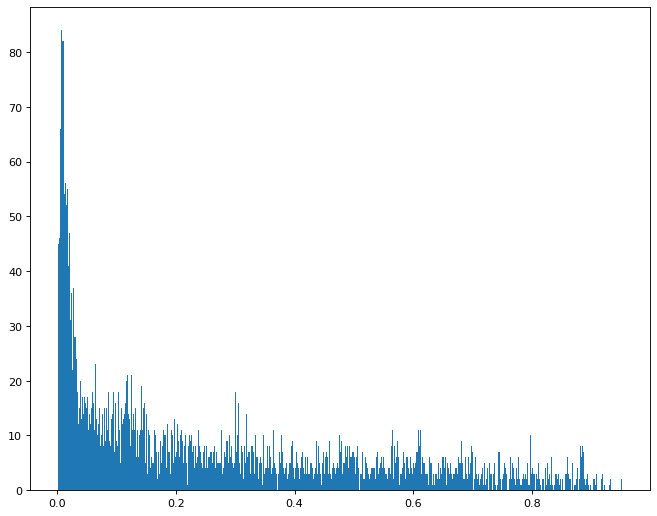

In [36]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.hist(x=df_data['probablity'], bins=1000)
plt.show()